In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import random
from scipy.stats import t, sem
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def generate_weekly_hours(personality_type, n_samples, mean, std):
    """
    Generate a sample of weekly hours (work or social activity) for a given personality type,
    using a truncated normal distribution and rounding to the nearest 0.5.
    
    Args:
    personality_type (str): The personality type.
    n_samples (int): The number of samples to generate.
    mean (float): The mean hours for the normal distribution.
    std (float): The standard deviation for the normal distribution.
    
    Returns:
    np.array: An array of generated weekly hours.
    """
    lower_bound, upper_bound = (0, 84)
    a, b = (lower_bound - mean) / std, (upper_bound - mean) / std
    sample = truncnorm(a, b, loc=mean, scale=std).rvs(n_samples)
    sample_rounded = np.round(sample * 2) / 2
    return sample_rounded

def generate_personality_hours_data(n_samples, personality_config):
    """
    Generate a DataFrame with weekly hours for specified proportions and types of personalities.
    
    Args:
    n_samples (int): The total number of samples to generate.
    personality_config (dict): Configuration for each personality, including proportion, mean, and std.
    
    Returns:
    pd.DataFrame: A DataFrame with personality types and corresponding weekly hours.
    """
    data = []
    for personality, config in personality_config.items():
        n_personality_samples = int(n_samples * config['proportion'])
        personality_hours = generate_weekly_hours(personality, n_personality_samples, config['mean'], config['std'])
        data.extend([(personality, hours) for hours in personality_hours])
    
    df = pd.DataFrame(data, columns=["Personality", "Weekly_Hours"])
    return df

In [3]:
# Configuration for each personality type (Type A, Type B, Type C)
personality_config = {
    'A': {'proportion': 0.29, 'mean': 50, 'std': 10},
    'B': {'proportion': 0.23, 'mean': 45.5, 'std': 8},
    'C': {'proportion': 0.48, 'mean': 47.5, 'std': 9}
}

In [35]:
# Generate
sample_size = random.randint(3_000_000, 5_000_000) 
generated_data = generate_personality_hours_data(sample_size, personality_config)
generated_data.head()


,Personality,Weekly_Hours
0,A,50.5
1,A,33.0
2,A,54.5
3,A,67.0
4,A,45.0


In [4]:
file_path = r"C:\Users\Admin\OneDrive - University of Gdansk (for Students)\Teaching\Statystyka\Statystyka\Dane\Wprowadzenie\Osobowosc.csv"

In [ ]:
# To save the generated dataset as a CSV file
generated_data.to_csv(file_path, index=False)

In [5]:
# Read data
generated_data = pd.read_csv(file_path)

In [6]:
def cohens_d(group1, group2):
    """
    Calculate Cohen's d for effect size between two groups.
    """
    # Calculate the size of samples
    n1, n2 = len(group1), len(group2)
    # Calculate the variance for each group
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    # Calculate the pooled standard deviation (s)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    # Calculate Cohen's d
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

In [7]:
def sample_effect_sizes(data, n, k, group_column, value_column):
    """
    Generate k samples of size n for each group, calculate Cohen's d for effect size between groups,
    and create a DataFrame with these effect sizes along with the sample indices.

    Parameters:
    - data: DataFrame containing the original data.
    - n: Size of each sample per group.
    - k: Number of samples to generate.
    - group_column: The column specifying the group (e.g., Type A or Type B).
    - value_column: The column from the data on which to calculate the effect size.

    Returns:
    - A DataFrame containing Cohen's d for each of the k samples and the indices of the samples.
    """
    effect_sizes = []
    sample_indices_a = []
    sample_indices_b = []
    
    for _ in range(k):
        # Sampling with replacement within each group and keeping track of the indices
        sample_a_indices = data[data[group_column] == 'A'].sample(n, replace=True).index
        sample_b_indices = data[data[group_column] == 'B'].sample(n, replace=True).index
        
        sample_a = data.loc[sample_a_indices, value_column]
        sample_b = data.loc[sample_b_indices, value_column]
        
        # Calculate Cohen's d
        d = cohens_d(sample_a, sample_b)
        
        effect_sizes.append(d)
        sample_indices_a.append(sample_a_indices.tolist())  # Store indices as a list
        sample_indices_b.append(sample_b_indices.tolist())
    
    # Create a DataFrame with the collected effect sizes and indices
    effect_size_df = pd.DataFrame({
        'Cohen_d': effect_sizes,
        'Sample_Indices_A': sample_indices_a,
        'Sample_Indices_B': sample_indices_b
    })
    
    return effect_size_df

# Example usage
# effect_sizes_df = sample_effect_sizes_with_tracking(df, n=50, k=100, group_column='Personality', value_column='Weekly_Hours')


In [8]:
# To generate 100 samples of size 50 per group and calculate effect sizes:
effect_sizes_df = sample_effect_sizes(generated_data, n=50, k=2000, group_column='Personality', value_column='Weekly_Hours')

In [9]:
def identify_and_store_subsamples(effect_sizes_df, data, population_d, group_column, value_column):
    """
    Identify subsamples based on Cohen's d criteria and store them in a dictionary of DataFrames.
    
    Parameters:
    - effect_sizes_df: DataFrame with effect sizes and sample indices.
    - data: Original DataFrame containing the data.
    - population_d: Population effect size for reference.
    - group_column, value_column: Column names for the group and the value.
    
    Returns:
    - A dictionary of DataFrames for the identified subsamples.
    """
    subsamples = {}
    
    # Identifying samples based on Cohen's d criteria
    criteria = {
        'close_to_population': np.abs(effect_sizes_df['Cohen_d'] - population_d).idxmin(),
        'non_significant': np.abs(effect_sizes_df['Cohen_d']).idxmin(),
        'reversed_effect': (effect_sizes_df['Cohen_d'] * np.sign(population_d)).idxmin(),
        'exaggerated_effect': effect_sizes_df['Cohen_d'].idxmax() if population_d > 0 else effect_sizes_df['Cohen_d'].idxmin()
    }
    
    for criterion, idx in criteria.items():
        sample_indices_a = effect_sizes_df.loc[idx, 'Sample_Indices_A']
        sample_indices_b = effect_sizes_df.loc[idx, 'Sample_Indices_B']
        
        # Extracting subsamples from the original data
        subsample = data.loc[sample_indices_a + sample_indices_b, [group_column, value_column]]
        
        # Storing subsamples in the dictionary
        subsamples[criterion] = subsample

    return subsamples

# Example usage

subsample_dict = identify_and_store_subsamples(effect_sizes_df, generated_data, 0.4889332, 'Personality', 'Weekly_Hours')


In [10]:
def calculate_basic_statistics_and_cohens_d(subsample_dict, group_column, value_column):
    """
    Calculate basic statistics and Cohen's d for each subsample in the dictionary.
    
    Parameters:
    - subsample_dict: Dictionary of DataFrames for the identified subsamples.
    - group_column: The column specifying the group (e.g., 'Type A' or 'Type B').
    - value_column: The column from the data on which to calculate the statistics.
    
    Returns:
    - A dictionary containing basic statistics and Cohen's d for each subsample.
    """
    statistics_results = {}
    
    for key, subsample in subsample_dict.items():
        # Separate the groups
        group_a = subsample[subsample[group_column] == 'A'][value_column]
        group_b = subsample[subsample[group_column] == 'B'][value_column]
        
        # Calculate basic statistics
        stats_a = {'mean': group_a.mean(), 'std_dev': group_a.std(), 'median': group_a.median()}
        stats_b = {'mean': group_b.mean(), 'std_dev': group_b.std(), 'median': group_b.median()}
        
        # Calculate Cohen's d
        d = cohens_d(group_a, group_b)
        
        # Store results
        statistics_results[key] = {
            'Statistics_Group_A': stats_a,
            'Statistics_Group_B': stats_b,
            'Cohens_d': d
        }
    
    return statistics_results

# Make sure to define the cohens_d function as before or include it within this function for completeness

# Example usage:

calculate_basic_statistics_and_cohens_d(subsample_dict, 'Personality', 'Weekly_Hours')



{'close_to_population': {'Statistics_Group_A': {'mean': 51.81,
   'std_dev': 10.763643454154511,
   'median': 51.5},
  'Statistics_Group_B': {'mean': 47.37,
   'std_dev': 7.007146497741883,
   'median': 46.75},
  'Cohens_d': 0.4888929203535624},
 'non_significant': {'Statistics_Group_A': {'mean': 49.56,
   'std_dev': 9.60900937789582,
   'median': 49.5},
  'Statistics_Group_B': {'mean': 49.48,
   'std_dev': 8.081195102564614,
   'median': 48.75},
  'Cohens_d': 0.009011009726204859},
 'reversed_effect': {'Statistics_Group_A': {'mean': 47.23,
   'std_dev': 8.768106630142622,
   'median': 46.5},
  'Statistics_Group_B': {'mean': 48.6,
   'std_dev': 9.575692014210794,
   'median': 48.0},
  'Cohens_d': -0.14922473661115782},
 'exaggerated_effect': {'Statistics_Group_A': {'mean': 53.18,
   'std_dev': 8.191434052516977,
   'median': 53.75},
  'Statistics_Group_B': {'mean': 43.59,
   'std_dev': 7.558405241578302,
   'median': 45.0},
  'Cohens_d': 1.2168077514683435}}

In [11]:
def identify_and_save_subsamples(effect_sizes_df, data, population_d, group_column, value_column, file_prefix):
    """
    Identify subsamples based on Cohen's d criteria and save them into separate files.
    
    Parameters:
    - effect_sizes_df: DataFrame with effect sizes and sample indices.
    - data: Original DataFrame containing the data.
    - population_d: Population effect size for reference.
    - group_column, value_column: Column names for the group and the value.
    - file_prefix: Prefix for the output file names.
    """
    # Identifying samples based on Cohen's d criteria
    criteria = {
        'close_to_population': np.abs(effect_sizes_df['Cohen_d'] - population_d).idxmin(),
        'non_significant': np.abs(effect_sizes_df['Cohen_d']).idxmin(),
        'reversed_effect': (effect_sizes_df['Cohen_d'] * np.sign(population_d)).idxmin(),
        'exaggerated_effect': effect_sizes_df['Cohen_d'].idxmax() if population_d > 0 else effect_sizes_df['Cohen_d'].idxmin()
    }
    
    for criterion, idx in criteria.items():
        sample_indices_a = effect_sizes_df.loc[idx, 'Sample_Indices_A']
        sample_indices_b = effect_sizes_df.loc[idx, 'Sample_Indices_B']
        
        # Extracting subsamples from the original data
        subsample = data.loc[sample_indices_a + sample_indices_b, [group_column, value_column]]
        
        # Saving subsamples to files
        filename = f"{file_prefix}_{criterion}.csv"
        subsample.to_csv(filename, index=False)
        print(f"Saved {criterion} sample to {filename}")

# Example usage
# Assuming 'effect_sizes_df' is the DataFrame output from the sample effect size tracking function,
# 'df' is your original DataFrame, and the population effect size 'population_d' is known:

# Example usage
# Assuming 'effect_sizes_df' is the DataFrame output from the sample effect size tracking function,
# 'df' is your original DataFrame, and the population effect size 'population_d' is known:
identify_and_save_subsamples(effect_sizes_df, generated_data, 0.4889332, 'Personality', 'Weekly_Hours', 'subsample')


Saved close_to_population sample to subsample_close_to_population.csv
Saved non_significant sample to subsample_non_significant.csv
Saved reversed_effect sample to subsample_reversed_effect.csv
Saved exaggerated_effect sample to subsample_exaggerated_effect.csv


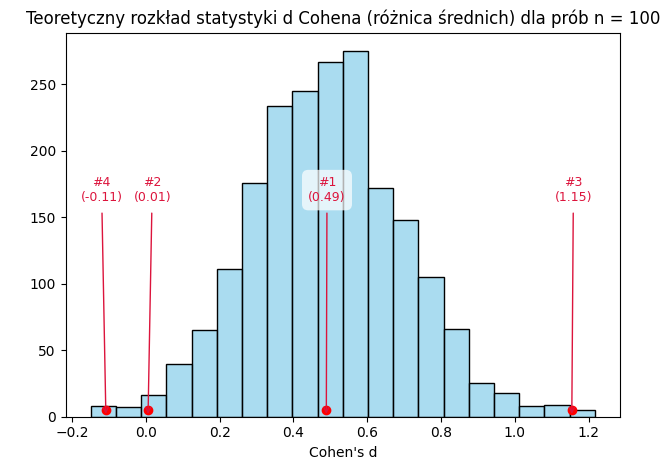

In [25]:

# Example statistics for special cases
special_cases = {
    '#1': 0.48902766896754457,
    '#2': 0.005761316872427656,
    '#4': -0.10842377897396231,
    '#3': 1.1544546651945995
}

# Plotting the histogram of effect sizes
fig, ax = plt.subplots()
sns.histplot(effect_sizes_df['Cohen_d'], kde=False, color="skyblue", binwidth=0.07, label='Effect Size Distribution', ax=ax, alpha = 0.7)
ax.set_xlabel('Cohen\'s d')
ax.set_ylabel(' ')
ax.set_title('Teoretyczny rozkład statystyki d Cohena (różnica średnich) dla prób n = 100')

# Annotations for special cases
for label, d_value in special_cases.items():
    # Mark the special case with a dot
    ax.plot(d_value, 5, 'o', color='red')

    # Adjust the text position for '#2' and '#4' to prevent overlap
    x_offset = 3 if label == '#2' else -3 if label == '#4' else 0

    # Add text annotation with an arrow
    ax.annotate(
        f'{label}\n({d_value:.2f})',
        xy=(d_value, 0),
        xytext=(d_value + x_offset, ax.get_ylim()[1] * 0.6),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='#DC143C'),
        ha='center', va='top', color='#DC143C', fontsize=9,
        xycoords='data',
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='none', alpha=0.7),
    )

plt.tight_layout()
plt.show()

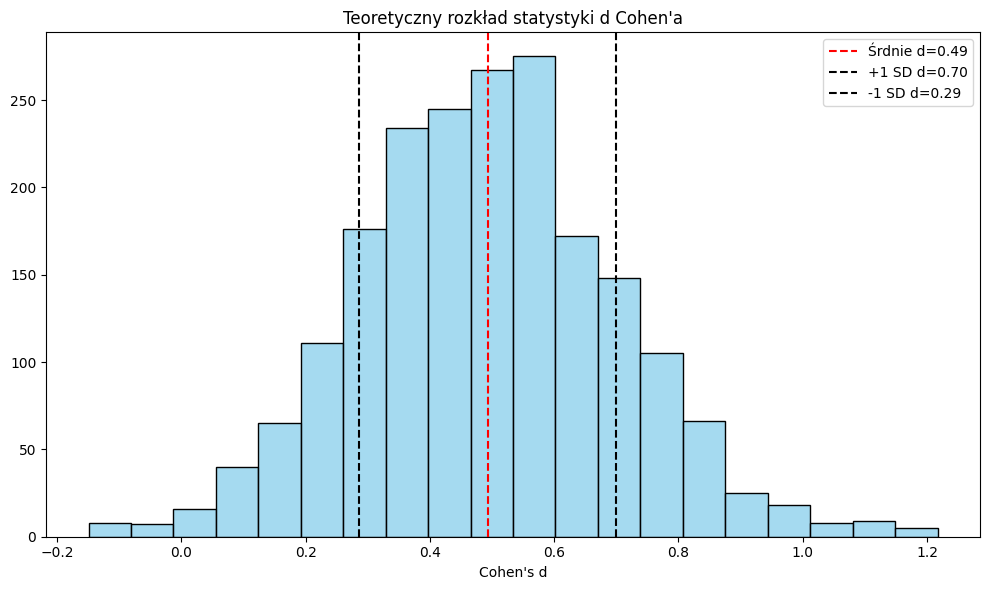

In [34]:
# Calculate the mean and standard deviation of the effect sizes
mean_cohens_d = np.mean(effect_sizes_df['Cohen_d'])
std_cohens_d = np.std(effect_sizes_df['Cohen_d'], ddof=1)

# Plotting the histogram of effect sizes
plt.figure(figsize=(10, 6))
sns.histplot(effect_sizes_df['Cohen_d'], kde=False, color="skyblue", binwidth=0.07)
plt.axvline(mean_cohens_d, color='red', linestyle='--', label=f'Śrdnie d={mean_cohens_d:.2f}')
# Standard deviation lines
plt.axvline(mean_cohens_d + std_cohens_d, color='black', linestyle='--', label=f'+1 SD d={mean_cohens_d + std_cohens_d:.2f}')
plt.axvline(mean_cohens_d - std_cohens_d, color='black', linestyle='--', label=f'-1 SD d={mean_cohens_d - std_cohens_d:.2f}')
plt.xlabel('Cohen\'s d')
plt.ylabel('')
plt.title('''Teoretyczny rozkład statystyki d Cohen'a''')
plt.legend()

plt.tight_layout()
plt.show()


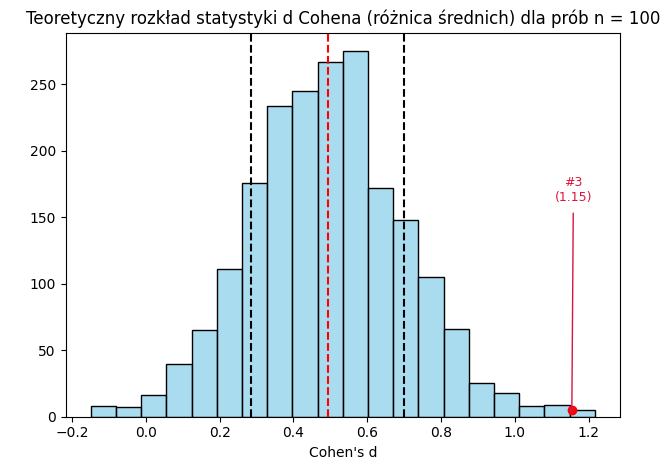

In [32]:

# Example statistics for special cases
special_cases = {
    '#3': 1.1544546651945995
}

# Plotting the histogram of effect sizes
fig, ax = plt.subplots()
sns.histplot(effect_sizes_df['Cohen_d'], kde=False, color="skyblue", binwidth=0.07, label='Effect Size Distribution', ax=ax, alpha = 0.7)
ax.set_xlabel('Cohen\'s d')
ax.set_ylabel(' ')
ax.set_title('Teoretyczny rozkład statystyki d Cohena (różnica średnich) dla prób n = 100')

# Annotations for special cases
for label, d_value in special_cases.items():
    # Mark the special case with a dot
    ax.plot(d_value, 5, 'o', color='red')

    # Adjust the text position for '#2' and '#4' to prevent overlap
    x_offset = 3 if label == '#2' else -3 if label == '#4' else 0

    # Add text annotation with an arrow
    ax.annotate(
        f'{label}\n({d_value:.2f})',
        xy=(d_value, 0),
        xytext=(d_value + x_offset, ax.get_ylim()[1] * 0.6),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='#DC143C'),
        ha='center', va='top', color='#DC143C', fontsize=9,
        xycoords='data',
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='none', alpha=0.7),
    )
plt.axvline(mean_cohens_d, color='red', linestyle='--', label=f'Średnia d={mean_cohens_d:.2f}')
# Standard deviation lines
plt.axvline(mean_cohens_d + std_cohens_d, color='black', linestyle='--', label=f'+1 SD d={mean_cohens_d + std_cohens_d:.2f}')
plt.axvline(mean_cohens_d - std_cohens_d, color='black', linestyle='--', label=f'-1 SD d={mean_cohens_d - std_cohens_d:.2f}')
plt.tight_layout()
plt.show()